# Final Report

## Introduction

We, Gideon Keith-Stanley and Tyler Short, strove to find out if we could use a natural language processing algorithm along with other machine learning techniques to determine if a video game description could predict, with any reliability, what genre(s) the game falls under. 

The PC Games 2020 dataset contains the results of scraping and sorting the entire catalog of Valve's "Steam" video game store, and includes data on over 27,000 titles. These data include title, description, genre, price points, several success metrics, and more. We hypothesize that using the "bag of words" method as seen in email spam filters, we can train a machine learning model using the digested description of video games, and use that information to classify games by genre.

## Data Capture

These methods were written to pull our data from the arff file. 

In [2]:
import numpy as np
import pandas as pd
import arff
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

from urllib.request import urlretrieve

def load_game_data():
    url = 'https://api.openml.org/data/v1/download/22102514/PC-Games-2020.arff'
    filename = 'pc_game_dataset.arff'
    file, http_response = urlretrieve(url, filename)
    dataset = arff.load(open(file, 'r'))
    attributes = np.array(dataset['attributes'])
    data = np.array(dataset['data'])
    data = clean_data(data)
    return data, attributes

# Use this to save bandwidth and time if the project has the data file already downloaded
def load_game_data_from_file():
    file = 'pc_game_dataset.arff'
    dataset = arff.load(open(file, 'r'))
    attributes = np.array(dataset['attributes'])
    data = np.array(dataset['data'])
    data = clean_data(data)
    return data, attributes

def clean_data(data):
    result = []
    for element in data:
        if element[6] != "" and element[6] is not None and element[25] != "" and element[25] is not None:
            result.append(element)
    return np.array(result)

A, b = load_game_data_from_file()

## Data Pre-Processing - Natural Language Processing with TfidfVectorizer

During this step, we first isolate our label vector 'genre' and convert it into a usable y for train and test sets. Once y_labels is populated with all of the available genres in a set (to prevent duplicates to be added), y is created by creating a vector of 1s (genre present) and 0s (genre absent) to give us a method for binary classification. In the end, each y is an ordered vector that contains N 0s and 1s where N is the number of genres and the 1 and 0s correlate to the one or more genres listed for the game.

For our X data matrix, we want to look at game descriptions, which in this case requires a strategy for Natural Language Processing. This allows us to quantify the words in the description for use in our machine learning algorithms. In our initial plan we wanted to implement the Box of Words algorithm, where we would 'tokenize' the words in each description compared to a ~20k word dictionary after removing stop words and create a number vector representing the presence of a dictionary word in the definition. 

However, we found that a scikit tool called TfidfVectorizor basically performed these same steps in a much easier to implement fashion so that is what we ultimately used as our NLP strategy for the X data matrix. This tool is a combination of two other scikit tools, CountVectorizer and TfidfTransformer. CountVectorizer does a lot of the work that Bag of Words did in quantifying and tokenizing the words in the descriptions. TfidfTransformer goes a step further and generates a data matrix from CountVectorizer that analyzes word frequency and "inverse document frequency"(the 'uniqueness' of a word) to further reduce the impact of 'noise' words in the descriptions. 

After the below code is run, the data previously captured is split into our familiar X data and y label variables. The X data matrix contains the information from the descriptions in the form of the TfidfTransformer matrix while the y label vector contains a list of arrays that correlate to the assigned genres for each matching game. 

In [3]:
import string

def process_string(subject):
    term = subject.strip()
    term = str.lower(term)
    term = term.translate(str.maketrans("","", string.punctuation))
    return term

results = set([])
genres = A[:,6]
for entry in genres:
    terms = str(entry).split(',')
    for term in terms:
        results.add(process_string(term))
y_labels = list(results)

y = []
for entry in A:
    y_row = [0] * len(y_labels)
    for genre in str(entry[6]).split(','):
        y_row[y_labels.index(process_string(genre))] = 1
    y.append(y_row)
    
    
y = np.array(y)

docs = [str(n) for n in A[:,25]]
tv = TfidfVectorizer(smooth_idf=True, sublinear_tf=True, max_df=0.5, min_df=5, lowercase=True, stop_words='english')
tv_result = tv.fit_transform(docs)
X = tv_result

print(X.shape)
print(y.shape)

(27094, 22979)
(27094, 20)


## Analysis

[words about our methodology and using LinearSVC and RandomForest, maybe put discussion about hyperparameter testing here]

### LinearSVC

[some notes about methodology and finding hyperparamaters]

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

#LinearSVC
results = []
for state in range(10):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = state)
    classifier = OneVsRestClassifier(LinearSVC(C=0.9, loss='hinge', max_iter=50000))
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    results.append(np.mean(y_pred == y_test))
print(np.mean(results))

C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 18 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 14 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 18 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 19 is present in all training examples.
  warnings.

0.9232402509533768


##### Confusion Matrix

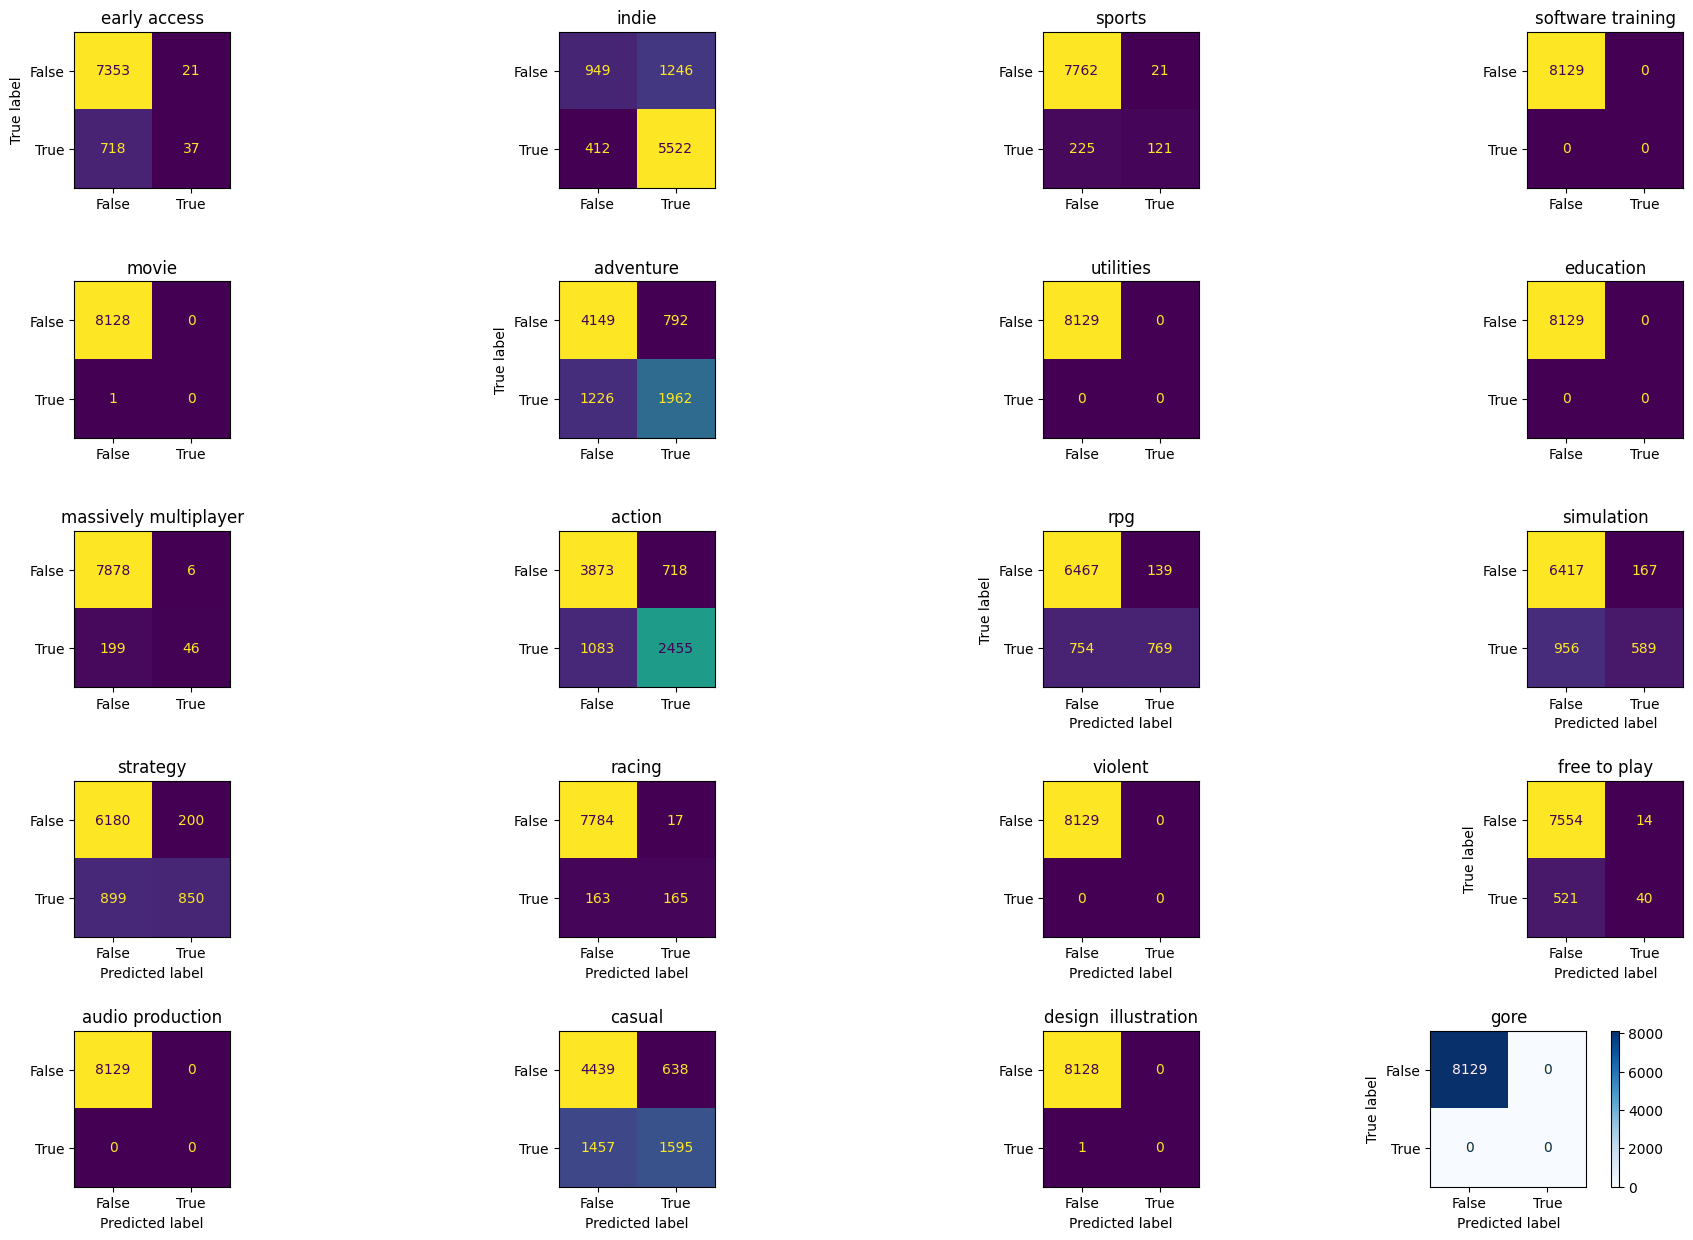

In [6]:
from sklearn.metrics import multilabel_confusion_matrix as mcm
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf = mcm(y_test, y_pred)

f, axes = plt.subplots(5, 4, figsize=(25, 15))
axes = axes.ravel()
for i in range(len(conf)):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf[i], display_labels=("False", "True"))
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(y_labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0, hspace=0.6)
disp.plot(ax=plt.gca(), include_values=True, cmap=plt.cm.Blues)
plt.show()

##### Accuracy by Genre

In [7]:
genres = []
accuracy = []

for z in range(len(y_labels)):
    tmp = y[:,z]
    results = []
    for state in range(10):
        x_train, x_test, y_train, y_test = train_test_split(X, tmp, test_size = 0.3, random_state = state)
        classifier = OneVsRestClassifier(LinearSVC(C=0.9, loss='hinge', max_iter=50000))
        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)
        results.append(np.mean(y_pred == y_test))
    genres.append(y_labels[z])
    accuracy.append(np.mean(results))

C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 0 is present in all training examples.
  warnings.warn

In [8]:
df = pd.DataFrame(accuracy, genres)
df

,0
early access,0.911600
indie,0.795535
sports,0.969640
software training,0.999988
movie,0.999938
adventure,0.754226
utilities,0.999975
education,0.999988
massively multiplayer,0.973736
action,0.782605


### RandomForest

[some notes about methodology and finding hyperparamaters]

In [9]:
from sklearn.ensemble import RandomForestClassifier

results = []
for state in range(10):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = state)
    classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    results.append(np.mean(y_pred == y_test))
print(np.mean(results))

0.9115659982777709


##### Confusion Matrix

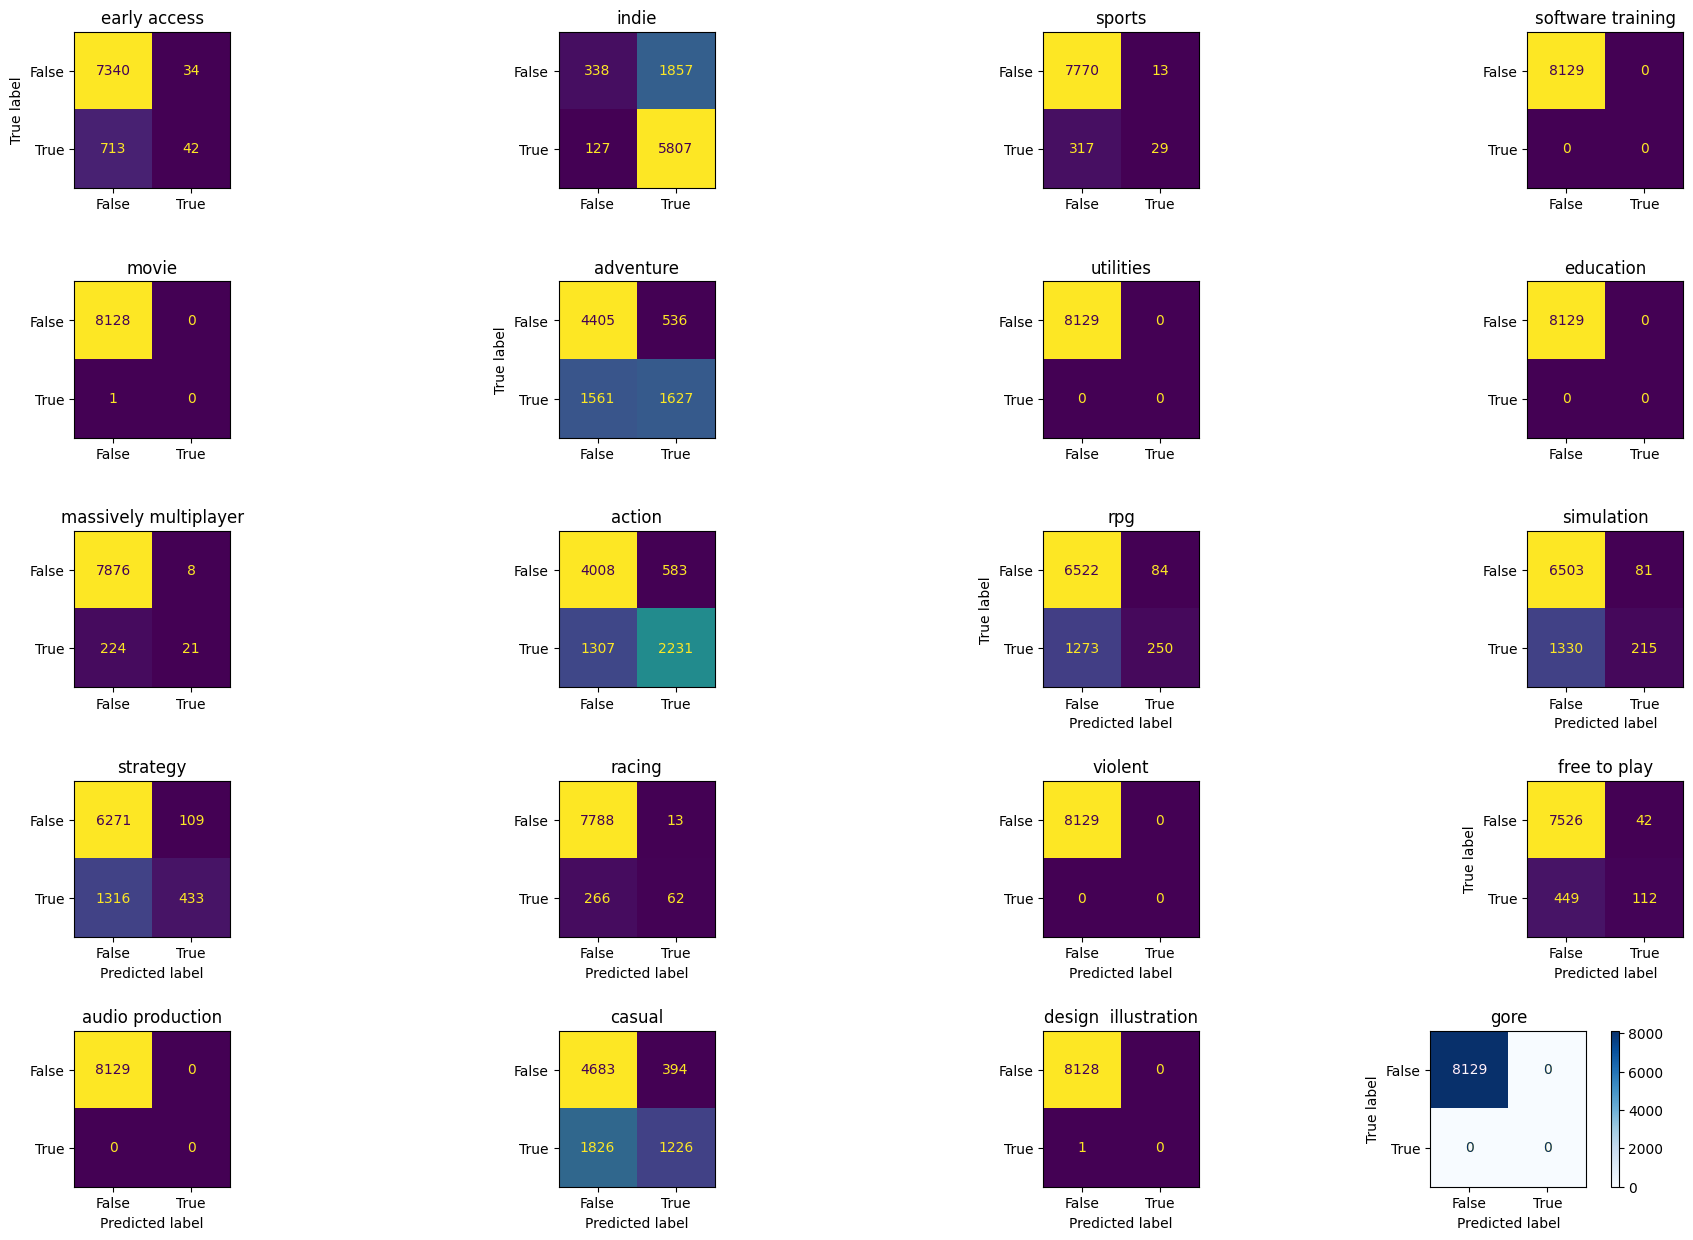

In [10]:
conf = mcm(y_test, y_pred)

f, axes = plt.subplots(5, 4, figsize=(25, 15))
axes = axes.ravel()
for i in range(len(conf)):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf[i], display_labels=("False", "True"))
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(y_labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0, hspace=0.6)
disp.plot(ax=plt.gca(), include_values=True, cmap=plt.cm.Blues)
plt.show()

##### Accuracy by Genre

In [12]:
genres = []
accuracy = []
for z in range(len(y_labels)):
    tmp = y[:,z]
    results = []
    for state in range(10):
        x_train, x_test, y_train, y_test = train_test_split(X, tmp, test_size = 0.3, random_state = state)
        classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1)
        classifier.fit(x_train,y_train)
        y_pred = classifier.predict(x_test)
        results.append(np.mean(y_pred == y_test))
    genres.append(y_labels[z])
    accuracy.append(np.mean(results))

In [ ]:
df = pd.DataFrame(accuracy, genres)
df

## Conclusions

[discussion about results and steps taken]